<h1>Dog Breed Classification</h1><br>
<br>

<a id='Intro'></a>
## <h1>Introduction</h1>

There are many different versions of dog breeds that are out there in the world. I will use image classification algorithms to provide the most accurate predictions of using deep learning tools which will predict different probabilities on different dog breeds that are detected in a dog image. 
<br>
The setup consists of a labels.csv file which consists of breed names and the image ids. There are two folders, test and train, that contain images of dogs. There will be training done on the images in the train folder. The Kaggle competition ended in February 2018, and if there is an opportunity in the future to submit my results, that will come up when it is most appropriate. In the meantime, for this project, I will not be submitting anything for the dog breed image classification project. 
<br>


<br>
The dataset comes from Kaggle, as the Dog Breed Identfication problem was a competition that was posted on their website. The citation can be found below.
<br>
Will Cukierski. Dog Breed Identification. https://kaggle.com/competitions/dog-breed-identification, 2017. Kaggle.
<br>


Notes:<br>
This was executed on an Anaconda environment using the following packages and respective versions.
<br>
<ul>
<li>Python v3.12.2</li>
<li>Tensorflow v2.12.0</li>
<li>Keras v2.12.0</li>
<li>Numpy </li>
<li>Pandas </li>
<li>Matplotlib-base </li>
</ul>

In [1]:
# Import basic libraries
import pandas as pd
import numpy as np
import os

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(94)

In [2]:
# Get the current working directory
os.getcwd()

'/Users/mjchin/Desktop/CUB_OMS_CS/Summer_2025/CSCA_5642_Intro_DL/FinalProject/dogbreedclassification'

In [3]:
os.getcwd()

'/Users/mjchin/Desktop/CUB_OMS_CS/Summer_2025/CSCA_5642_Intro_DL/FinalProject/dogbreedclassification'

In [185]:
train_dir = 'dog-breed-identification/train/'
from os.path import join

for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        os.path.join(dirname, filename)


<a id='EDA'></a>
## <h1>Exploratory Data Analysis</h1>

Take a look at some of the labels to get an understanding of the data that involves dog breeds. Open the CSV file and we will see the respective image IDs tied to a different dog breed.

In [186]:
# The path to the files should not be like this all the time; everything done offline
# Actual project is found on Kaggle, but elected to run on own environment which best fit needs
labels = pd.read_csv("labels.csv")
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [187]:
os.getcwd()

'/Users/mjchin/Desktop/CUB_OMS_CS/Summer_2025/CSCA_5642_Intro_DL/FinalProject/dogbreedclassification'

In [188]:
train_path = 'train/'
test_path = 'test/'

Now, get some information on the overall strucutre of the labels database. This includes the shape, column names, type info, and descriptive statistics, among others.

In [189]:
labels.shape

(10222, 2)

In [190]:
labels.columns

Index(['id', 'breed'], dtype='object')

In [191]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [192]:
labels.isnull()

,id,breed
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
10217,False,False
10218,False,False
10219,False,False
10220,False,False


In [193]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


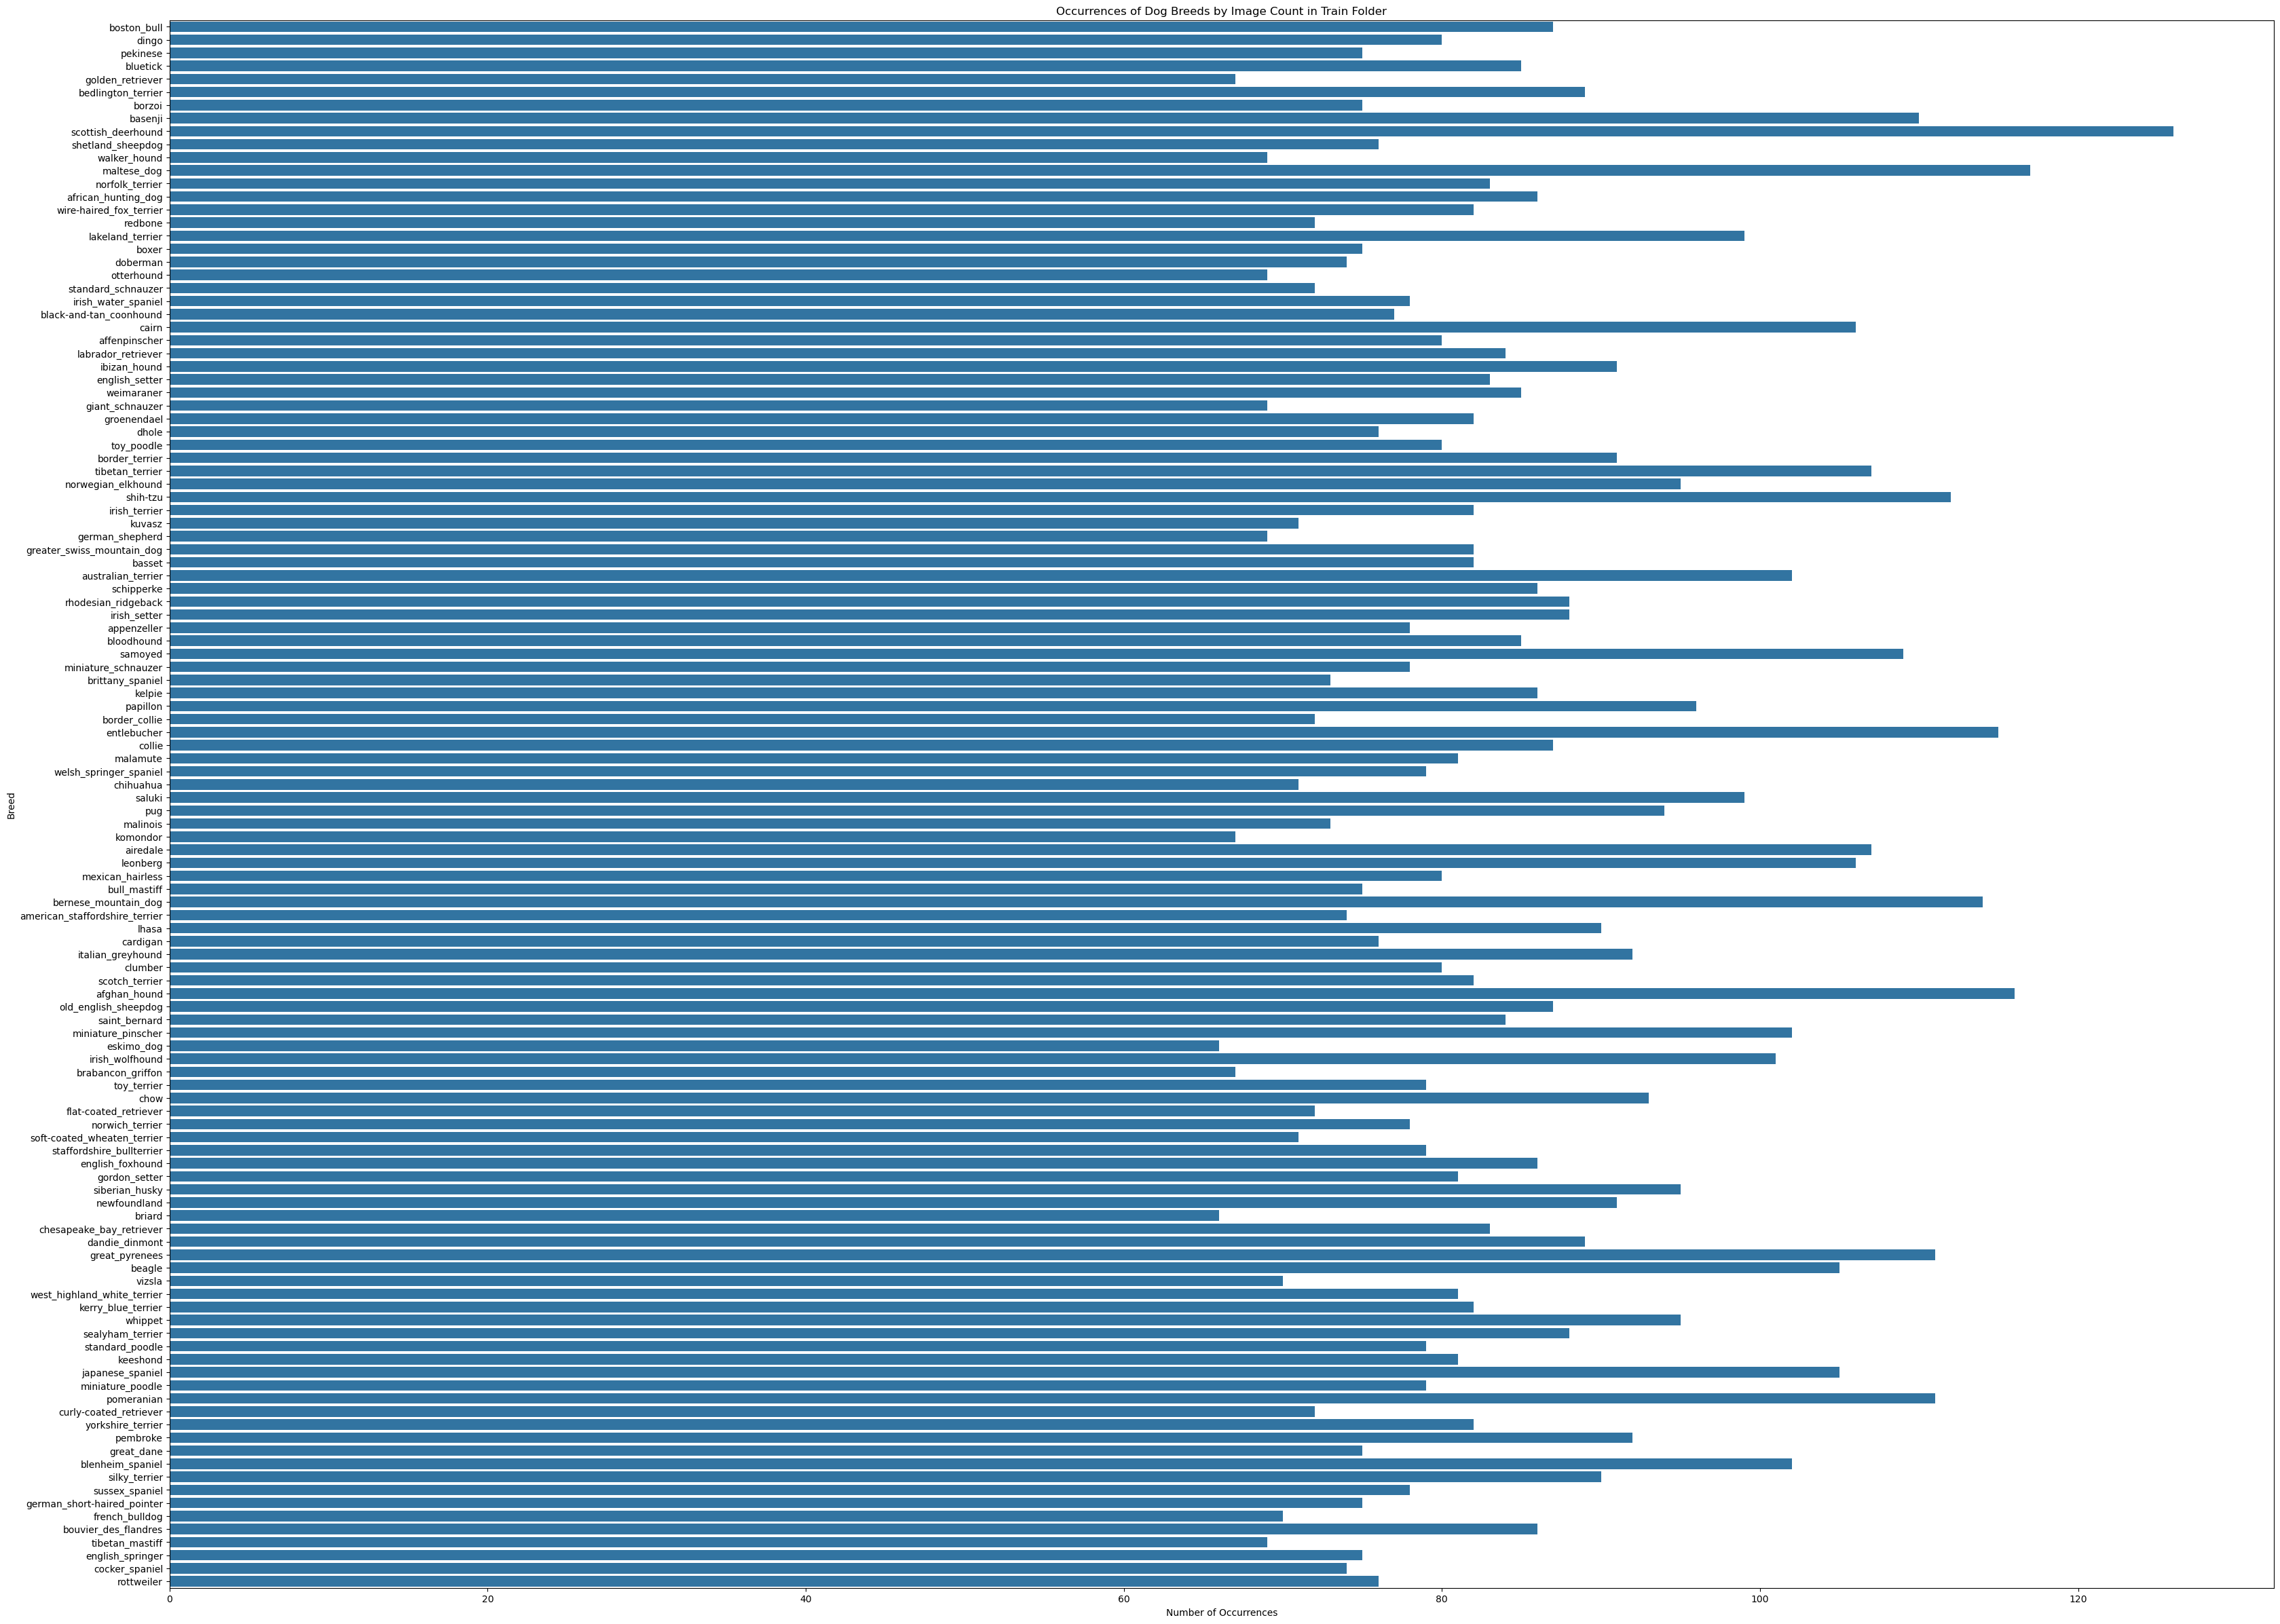

In [194]:
# Visualize dog breed counts
plt.figure(figsize=(40,30))
sns.countplot(y="breed",data=labels)
plt.xlabel("Number of Occurrences")
plt.ylabel("Breed")
plt.title("Occurrences of Dog Breeds by Image Count in Train Folder")
plt.show()

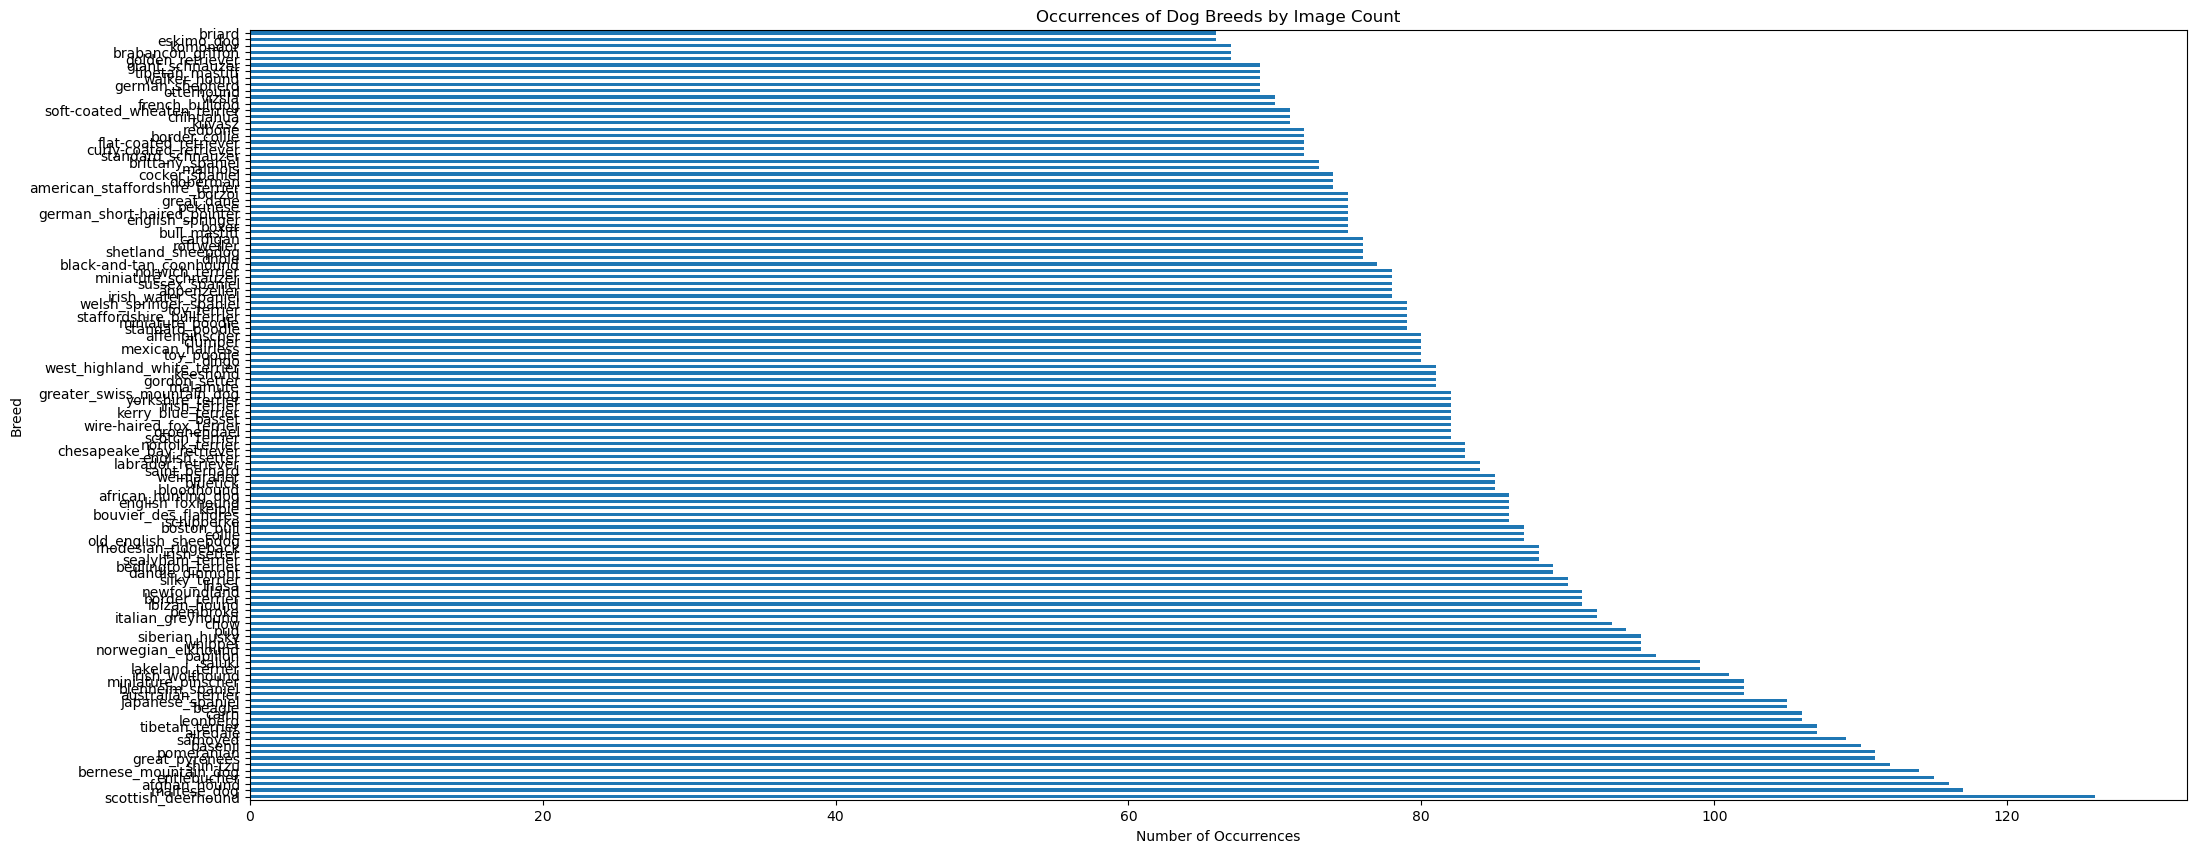

In [195]:
# Show all dog breed images occurrences in order, ascending from least to most
labels['breed'].value_counts().plot.barh(figsize=(25,10))
plt.xlabel("Number of Occurrences")
plt.ylabel("Breed")
plt.title("Occurrences of Dog Breeds by Image Count")
plt.show()

Get a few samples of images from train directory - note that the file types for the images ends in '.jpg'. 
First, use the Image package from the IPython library to get single images, then follow it up with multiple batches of images by dog breed.

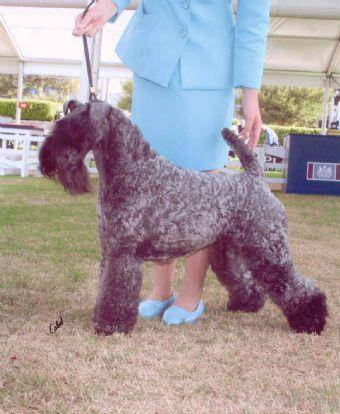

In [196]:
from IPython.display import Image
Image("dog-breed-identification/train/0a1f8334a9f583cac009dc033c681e47.jpg")

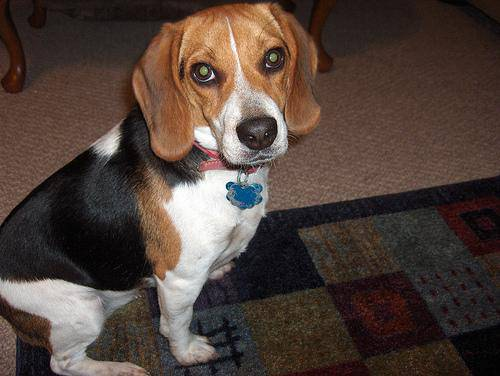

In [197]:
Image("dog-breed-identification/train/0b9d58d8d2626f80bbc5cc3ccf7e8bad.jpg")

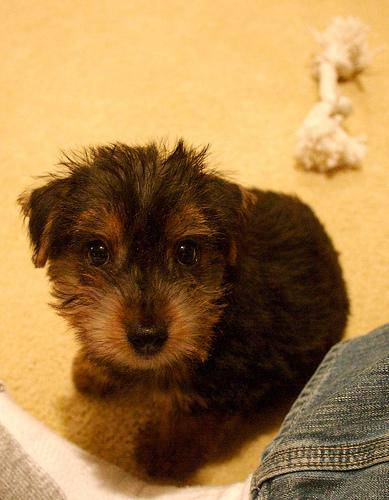

In [198]:
Image("dog-breed-identification/train/fc33f90570fc8502e6c3f83a6bf3b982.jpg")

Before doing batches of images by dog breed, take a look at what our goal is: to submit a file with appropriate labels to image IDs. 
<br>
Since this came from a Kaggle competition, take a look at the sample_submission.csv file that came with all the data that was downloaded locally. The purpose of this image classification is to predict the probability that a dog image consists of at least one of several different dog breeds. The higher the probability percentage, the more likely that that image is that dog breed.  
<br>
For the purpose of this project, we will not be submitting a CSV file, but will make one as if it is in the competition. I am using older versions of Python, TensorFlow, Keras, etc., due to past and present familiarity with these versions.

In [199]:
# Get first five rows of the sample submit file 
sample = pd.read_csv("sample_submission.csv")
sample.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [200]:
np.__version__

'1.26.4'

(291, 288, 3)
(375, 500, 3)
(375, 500, 3)
(333, 500, 3)
(356, 500, 3)
(375, 500, 3)
(342, 400, 3)
(375, 500, 3)
(389, 479, 3)
(375, 500, 3)


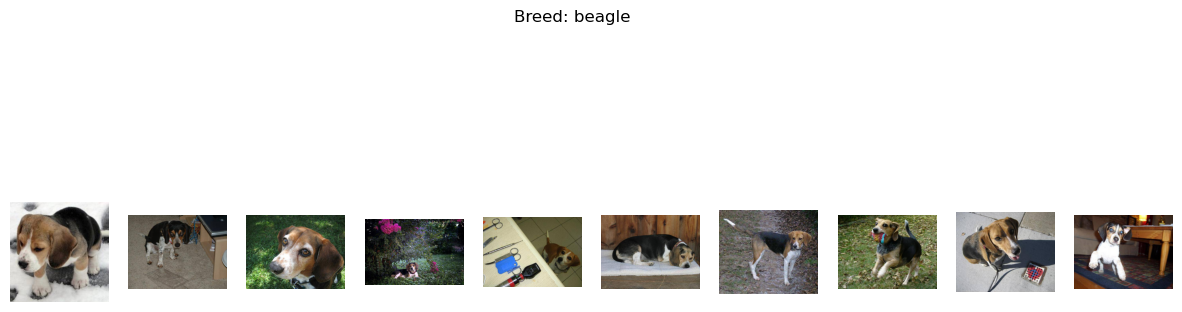

In [201]:
import cv2

# Also shows the image of any one shape - or the number of pixels on any one image
base_path='dog-breed-identification/train'
def show_samples(df, breed, n=10):
    samples = df[df['breed'] == breed].sample(n)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for img_id, ax in zip(samples['id'], axes):
        # img = get_image(img_id)
        path = os.path.join(base_path, f"{img_id}.jpg")
        img = cv2.imread(path)
        print(img.shape)

        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.suptitle(f"Breed: {breed}")
    plt.show()

# Show samples of beagles
show_samples(labels, breed='beagle')

In [202]:
# Get how many Beagle images there are in train dataset - should be 105
labels[labels['breed'] == 'beagle'].shape

(105, 2)

(418, 399, 3)
(480, 640, 3)
(500, 375, 3)
(375, 500, 3)
(333, 500, 3)
(500, 375, 3)
(500, 377, 3)
(375, 500, 3)
(200, 245, 3)
(500, 333, 3)


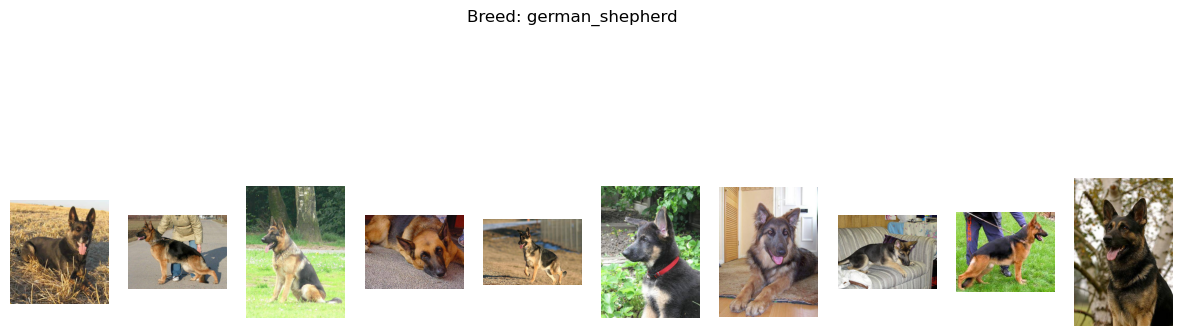

In [203]:
# Show samples of German Shepherds
show_samples(labels, breed='german_shepherd')

In [204]:
# Get how many German Shepherd images there are in train dataset - should be 69
labels[labels['breed'] == 'german_shepherd'].shape

(69, 2)

In [205]:
# Get value counts of all dog breeds occurrences from labels dataset
labels['breed'].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

It can be seen from the value counts that the breed with the most labels is the Scottish Deerhound, with 126.<br>
The dog breeds with the least number of labels from the labels CSV file are the Eskimo and Briard, with 66 occurrences each. 

In [206]:
len(labels['breed'])

10222

In [207]:
# Median number of value counts for a dog breed
labels['breed'].value_counts().median()

82.0

In [208]:
# Find how many unique breeds there are in the labels dataset
len(labels['breed'].unique())

120

In [209]:
# Get top 25 breeds with most occurring labels found
top25breeds= labels['breed'].value_counts().head(25)

# Type Series, convert to DataFrame
print(type(top25breeds))

top25breeds = top25breeds.reset_index()
print(type(top25breeds))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [210]:
# Get new top 25 breeds dataframe
print(top25breeds.shape)
print(top25breeds.columns)
print(top25breeds)

(25, 2)
Index(['breed', 'count'], dtype='object')
                   breed  count
0     scottish_deerhound    126
1            maltese_dog    117
2           afghan_hound    116
3            entlebucher    115
4   bernese_mountain_dog    114
5               shih-tzu    112
6         great_pyrenees    111
7             pomeranian    111
8                basenji    110
9                samoyed    109
10              airedale    107
11       tibetan_terrier    107
12              leonberg    106
13                 cairn    106
14                beagle    105
15      japanese_spaniel    105
16    australian_terrier    102
17      blenheim_spaniel    102
18    miniature_pinscher    102
19       irish_wolfhound    101
20      lakeland_terrier     99
21                saluki     99
22              papillon     96
23    norwegian_elkhound     95
24               whippet     95


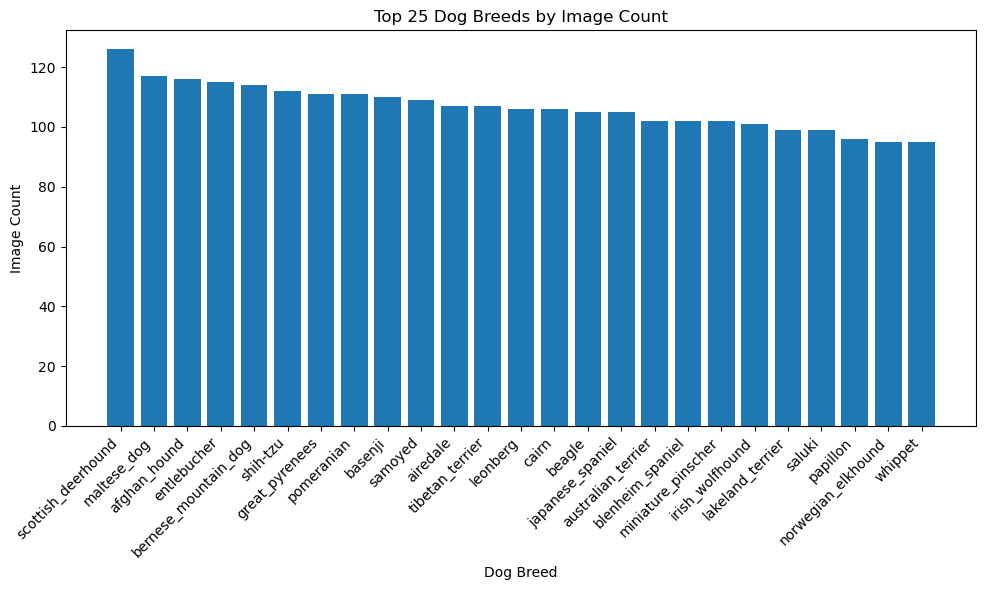

In [211]:
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
plt.bar(top25breeds['breed'], top25breeds['count'])
plt.xlabel("Dog Breed")
plt.ylabel("Image Count")
plt.title("Top 25 Dog Breeds by Image Count")
plt.xticks(range(len(top25breeds)), rotation=45, ha='right')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [212]:
# Get count of images in train directory 
len(os.listdir('dog-breed-identification/train'))

10222

In [213]:
# Get count of images in test directory
len(os.listdir('dog-breed-identification/test'))

10357

In [231]:
# Add folder path to image files
labels['path'] = labels['id'].apply(lambda x : train_dir + x + '.jpg')

In [232]:
labels.head()

,id,breed,path,breed_id
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,dog-breed-identification/train/000bec180eb18c7...,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,dog-breed-identification/train/001513dfcb2ffaf...,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,dog-breed-identification/train/001cdf01b096e06...,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,dog-breed-identification/train/00214f311d5d224...,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,dog-breed-identification/train/0021f9ceb3235ef...,49


<a id='Modeling Prep'></a>
## <h1>Model Preparation</h1>

After some visualizations, it is time to prepare our data. First, import the required libraries to prepare and split the data. Some preprocessing will need to be done because it can be seen that some of the images vary in size and therefore need to be standardized for the model to run properly to generate probabilities on which dog breed an image is. Set up some constants so that the deep learning pipeline workflow process remains constant for the modeling. 
<br> 

Additionally, set up any and all necessary directories to separate the images for the pre-training of image classification. There will be a base directory, followed by train and validation subdirectories. There also requires the need for base, train, and validation directories. 
<br>

Let's compare some of the Keras models and import many of the needed TensorFlow and Scikit-learn libraries that will be needed.
<br>


In [233]:
# Import TensorFlow, Keras, Scikit-learn libraries to be used

import tensorflow as tf # Use tf v2.12.0
import keras
from keras import layers, models, callbacks, optimizers
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

tf.random.set_seed(104)

In [234]:
# Get the TensorFlow Version - we are using v2.12.0
print(tf.__version__, keras.__version__)

2.17.0 3.4.1


In [235]:
# Set up constants for model
RANDOM_STATE = 50
IMG_SIZE = 256
DOG_BREEDS = len(labels['breed'].unique())
LEARNING_RATE = 0.005
BATCH_SIZE = 32

# Epochs value may vary based on number of tests
EPOCHS = 5

In [236]:
# Create a label encoding
encoder = LabelEncoder()
labels['breed_id']= encoder.fit_transform(labels['breed'])
labels.head()


,id,breed,path,breed_id
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,dog-breed-identification/train/000bec180eb18c7...,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,dog-breed-identification/train/001513dfcb2ffaf...,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,dog-breed-identification/train/001cdf01b096e06...,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,dog-breed-identification/train/00214f311d5d224...,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,dog-breed-identification/train/0021f9ceb3235ef...,49


In [237]:
# Get all dog breeds once more and total number of unique breeds from labels dataframe
print(labels['breed'].unique(), '\n',
      len(labels['breed'].unique()))

['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 'cairn' 'affenpinscher'
 'labrador_retriever' 'ibizan_hound' 'english_setter' 'weimaraner'
 'giant_schnauzer' 'groenendael' 'dhole' 'toy_poodle' 'border_terrier'
 'tibetan_terrier' 'norwegian_elkhound' 'shih-tzu' 'irish_terrier'
 'kuvasz' 'german_shepherd' 'greater_swiss_mountain_dog' 'basset'
 'australian_terrier' 'schipperke' 'rhodesian_ridgeback' 'irish_setter'
 'appenzeller' 'bloodhound' 'samoyed' 'miniature_schnauzer'
 'brittany_spaniel' 'kelpie' 'papillon' 'border_collie' 'entlebucher'
 'collie' 'malamute' 'welsh_springer_spaniel' 'chihuahua' 'saluki' 'pug'
 'malinois' 'komondor' 'airedale' 'leonberg' 'mexican_h

In [239]:
# class Dog_Breed_Dataset(Dataset):
    
#     def __init__(self, df: pd.DataFrame, img_base_path: str, split: str, transforms = None):        
#         self.df = df
#         self.img_base_path = img_base_path
#         self.split = split
#         self.transforms = transforms
        
#     def __getitem__(self, index):
#         # Path of the image
#         img_path = os.path.join(self.img_base_path + self.df.loc[index,'id'] + '.jpg')
#         # Read the image
#         img = Image.open(img_path)        
#         # Perform the transformations
#         if self.transforms:
#             img = self.transforms(img)
        
#         if self.split != 'test':
#             y = self.df.loc[index, 'breed']                     
#             return img, y
#         else:            
#             return img
    
#     def __len__(self):
#         return len(self.df)        

In [241]:
img=cv2.imread('dog-breed-identification/test/000621fb3cbb32d8935728e48679680e.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [242]:
img

array([[[121, 133,  87],
        [103, 114,  71],
        [106, 113,  72],
        ...,
        [102, 112,  25],
        [ 80,  89,  10],
        [ 91, 102,  24]],

       [[ 99, 108,  61],
        [ 86,  95,  48],
        [108, 115,  73],
        ...,
        [ 97, 107,  18],
        [ 69,  81,   0],
        [ 70,  82,   0]],

       [[ 84,  93,  40],
        [ 82,  91,  38],
        [107, 115,  66],
        ...,
        [ 83,  97,   2],
        [ 64,  77,   0],
        [ 66,  79,   0]],

       ...,

       [[ 27,  65,  26],
        [  0,  27,   0],
        [ 16,  45,  14],
        ...,
        [ 50,  75,  46],
        [ 32,  57,  28],
        [ 53,  78,  49]],

       [[ 31,  72,  32],
        [ 12,  50,  11],
        [ 14,  45,  11],
        ...,
        [ 16,  39,  13],
        [ 13,  36,  10],
        [ 56,  79,  53]],

       [[ 44,  79,  39],
        [ 36,  70,  33],
        [ 37,  69,  32],
        ...,
        [ 33,  51,  29],
        [  9,  28,   6],
        [ 43,  62,  40]]

In [ ]:
'''Set up variables x, y to load images from train_dir into array/matrix form (seen in last cell)
Adjust size as appropriate and put everything in list form
Create dataset y of dummy variables of dog breeds and then get shapes

x - type numpy array
y - type dataframe
'''


x= np.array([img_to_array(load_img(image, target_size=(IMG_SIZE, IMG_SIZE)))
             for image in labels['path'].values.tolist()])
y = pd.get_dummies(labels['breed'])
print(x.shape, y.shape)

(10222, 256, 256, 3) (10222, 120)


In [246]:
# paths = labels['path']
# target = labels['breed']
# x_train, x_valid, y_train, y_valid = train_test_split(paths, target, test_size=0.2, random_state=RANDOM_STATE)

# Do the train-test split
# Implement the training and validation sets for x, y so that train-test size is 80%-20%
# Pass 
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)

(8177, 256, 256, 3) (8177, 120)
(2045, 256, 256, 3) (2045, 120)


In [ ]:
# Implement some model comparisons

from keras.applications import (MobileNetV2, 
                                            ResNet50, 
                                            ResNet101, 
                                            Xception, 
                                            InceptionResNetV2, 
                                            InceptionV3,
                                            NASNetLarge, 
                                            NASNetMobile,
                                            EfficientNetB0, 
                                            VGG16, 
                                            VGG19)

# Dictionary to map model names to their corresponding classes
models_dict = {
    "mobilenetv2": MobileNetV2,
    "resnet50": ResNet50,
    "resnet101": ResNet101,
    "xception": Xception,
    "inceptionresnetv2": InceptionResNetV2,
    "inceptionv3": InceptionV3,
    "nasnetlarge": NASNetLarge,
    "nasnetmobile": NASNetMobile,
    "efficientnetb0": EfficientNetB0,
    "vgg16": VGG16,
    "vgg19": VGG19,
    "sequential": Sequential
}

In [127]:
# Check if GPU is available

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU being used for training")
    for gpu in gpus:
        print(f"GPU Name: {gpu.name}")
else: # Use CPU
    BATCH_SIZE=16
    EPOCHS = 5
    print("Using CPU")


Using CPU


In [112]:
# Compare different Keras models
# Source: https://medium.com/@avinashkella/a-comprehensive-guide-to-comparing-pretrained-deep-learning-models-in-tensorflow-e22e8c1abcf4


def compare_models(model1_name, model2_name):
    model1 = models_dict[model1_name](weights='imagenet')
    model2 = models_dict[model2_name](weights='imagenet')
    
    # Compare model architectures
    print(f"Model architectures: {model1_name} vs {model2_name}")
    print(model1.summary())
    print(model2.summary())
    print("--------------------------------------------")
    
    # Compare number of parameters
    params_model1 = model1.count_params()
    params_model2 = model2.count_params()
    print(f"Number of parameters in {model1_name}: {params_model1}")
    print(f"Number of parameters in {model2_name}: {params_model2}")
    print("--------------------------------------------")
    
    # Compare number of layers
    num_layers_model1 = len(model1.layers)
    num_layers_model2 = len(model2.layers)
    print(f"Number of layers in {model1_name}: {num_layers_model1}")
    print(f"Number of layers in {model2_name}: {num_layers_model2}")
    print("--------------------------------------------")
    
    # Compare input shapes
    input_shape_model1 = model1.input_shape
    input_shape_model2 = model2.input_shape
    print(f"Input shape of {model1_name}: {input_shape_model1}")
    print(f"Input shape of {model2_name}: {input_shape_model2}")
    print("--------------------------------------------")
    
    # Compare output shapes
    output_shape_model1 = model1.output_shape
    output_shape_model2 = model2.output_shape
    print(f"Output shape of {model1_name}: {output_shape_model1}")
    print(f"Output shape of {model2_name}: {output_shape_model2}")
    print("--------------------------------------------")
    
    # Compare layer types
    layers_model1 = [layer.__class__.__name__ for layer in model1.layers]
    layers_model2 = [layer.__class__.__name__ for layer in model2.layers]
    print(f"Layer types in {model1_name}: {layers_model1}")
    print(f"Layer types in {model2_name}: {layers_model2}")
    print("--------------------------------------------")
    
    # Compare normalization layers
    normalization_layers_model1 = [layer.__class__.__name__ for layer in model1.layers if isinstance(layer, tf.keras.layers.BatchNormalization)]
    normalization_layers_model2 = [layer.__class__.__name__ for layer in model2.layers if isinstance(layer, tf.keras.layers.BatchNormalization)]
    print(f"Normalization layers in {model1_name}: {normalization_layers_model1}")
    print(f"Normalization layers in {model2_name}: {normalization_layers_model2}")
    print("--------------------------------------------")
    
    # Compare skip connections
    skip_connections_model1 = any(isinstance(layer, tf.keras.layers.Add) or isinstance(layer, tf.keras.layers.Concatenate) for layer in model1.layers)
    skip_connections_model2 = any(isinstance(layer, tf.keras.layers.Add) or isinstance(layer, tf.keras.layers.Concatenate) for layer in model2.layers)
    print(f"Skip connections in {model1_name}: {skip_connections_model1}")
    print(f"Skip connections in {model2_name}: {skip_connections_model2}")
    print("--------------------------------------------")
    
    # Compare model size
    model_size_model1 = model1_size = sum([tf.keras.backend.count_params(w) for w in model1.trainable_weights])
    model_size_model2 = model2_size = sum([tf.keras.backend.count_params(w) for w in model2.trainable_weights])
    print(f"Model size of {model1_name}: {model_size_model1}")
    print(f"Model size of {model2_name}: {model_size_model2}")
    print("--------------------------------------------")
    
    # Compare pooling layers
    pooling_layers_model1 = [layer.__class__.__name__ for layer in model1.layers if isinstance(layer, tf.keras.layers.MaxPooling2D) or isinstance(layer, tf.keras.layers.AveragePooling2D)]
    pooling_layers_model2 = [layer.__class__.__name__ for layer in model2.layers if isinstance(layer, tf.keras.layers.MaxPooling2D) or isinstance(layer, tf.keras.layers.AveragePooling2D)]
    print(f"Pooling layers in {model1_name}: {pooling_layers_model1}")
    print(f"Pooling layers in {model2_name}: {pooling_layers_model2}")
    print("--------------------------------------------")


In [113]:
compare_models("vgg16", "vgg19")

Model architectures: vgg16 vs vgg19


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,31

 Total params: 143,667,240 (548.05 MB)

 Trainable params: 143,667,240 (548.05 MB)

 Non-trainable params: 0 (0.00 B)

None
--------------------------------------------
Number of parameters in vgg16: 138357544
Number of parameters in vgg19: 143667240
--------------------------------------------
Number of layers in vgg16: 23
Number of layers in vgg19: 26
--------------------------------------------
Input shape of vgg16: (None, 224, 224, 3)
Input shape of vgg19: (None, 224, 224, 3)
--------------------------------------------
Output shape of vgg16: (None, 1000)
Output shape of vgg19: (None, 1000)
--------------------------------------------
Layer types in vgg16: ['InputLayer', 'Conv2D', 'Conv2D', 'MaxPooling2D', 'Conv2D', 'Conv2D', 'MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D', 'MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D', 'MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D', 'MaxPooling2D', 'Flatten', 'Dense', 'Dense', 'Dense']
Layer types in vgg19: ['InputLayer', 'Conv2D', 'Conv2D', 'MaxPooling2D', 'Conv2D', 'Conv2D', 'MaxPooling2D', 'Conv2D', 'Conv2D', 'Conv2D', 'Conv2D', 'MaxPooling2D', 'Conv2D', 'Conv2D', 'C

<a id='Modeling'></a>
## <h1>Modeling</h1>

Create the ImageDataGenerators and align them properly to the datasets and values they are to be associated to prior to modeling. Layers are to be created before compilation and data fitting. 

In [259]:
# Create one model using Sequential
model = Sequential()

In [260]:
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Dropout,Flatten,Activation

model.add(Conv2D(32,(3,3),input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(LeakyReLU(alpha=0.01))
# model.add(Activation('relu'))

model.add(MaxPool2D((2,2)))

model.add(Conv2D(64,(3,3)))
model.add(LeakyReLU(alpha=0.01))
# model.add(Activation('relu'))

model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3)))
model.add(LeakyReLU(alpha=0.01))
# model.add(Activation('relu'))

model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3)))
model.add(LeakyReLU(alpha=0.01))
# model.add(Activation('relu'))

model.add(MaxPool2D((2,2)))

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(512))
model.add(LeakyReLU(alpha=0.01))
# model.add(Activation('relu'))

model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_288 (Conv2D)             │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_289 (Conv2D)             │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_290 (Conv2D)             │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_291 (Conv2D)             │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 120)            │        61,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1062 (Activation)    │ (None, 120)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,147,960 (50.16 MB)

 Trainable params: 13,147,960 (50.16 MB)

 Non-trainable params: 0 (0.00 B)

In [261]:
# Model Compilation
model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy']
)

In [262]:
EPOCHS

5

In [263]:
# Fit data into the model
history = model.fit(x_train, y_train,
         epochs=EPOCHS,
         batch_size=BATCH_SIZE,
         steps_per_epoch=x_train.shape[0]//BATCH_SIZE,
         validation_steps=x_valid.shape[0]//BATCH_SIZE,
         validation_data=(x_valid, y_valid),
         verbose=2)

Epoch 1/5
255/255 - 138s - 541ms/step - accuracy: 0.0097 - loss: 6.5396 - val_accuracy: 0.0079 - val_loss: 4.7874
Epoch 2/5
255/255 - 1s - 3ms/step - accuracy: 0.0000e+00 - loss: 4.8166 - val_accuracy: 0.0000e+00 - val_loss: 4.7824
Epoch 3/5


2025-06-22 23:36:19.758607: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2025-06-22 23:36:20.045475: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 - 136s - 532ms/step - accuracy: 0.0108 - loss: 4.7838 - val_accuracy: 0.0109 - val_loss: 4.7824
Epoch 4/5
255/255 - 0s - 2ms/step - accuracy: 0.0000e+00 - loss: 4.8081 - val_accuracy: 0.0345 - val_loss: 4.7744
Epoch 5/5


2025-06-22 23:38:36.095142: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


255/255 - 131s - 512ms/step - accuracy: 0.0127 - loss: 4.7811 - val_accuracy: 0.0139 - val_loss: 4.7807


In [270]:
# Run an ImageTestGenerator on validation data
test_gen = ImageDataGenerator()

test_set = test_gen.flow_from_directory('dog-breed-identification', target_size=(IMG_SIZE, IMG_SIZE), classes=['test'])

Found 10357 images belonging to 1 classes.


In [271]:
# Predict on the model using the test generator
y_pred = model.predict(test_set)

  1/324 ━━━━━━━━━━━━━━━━━━━━ 57s 179ms/step

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step


In [272]:
import re
file_list = test_set.filenames
id_list = []
for name in file_list:
    m = re.sub('test/', '', name)
    m = re.sub('.jpg', '', m)
    id_list.append(m)


In [273]:
submission = pd.read_csv('sample_submission.csv')
submission.head()
submission['id'] = id_list
submission.iloc[:,1:] =y_pred
submission.head()


,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.007615,0.010520,0.008273,0.010846,0.009866,0.008818,0.007996,0.012801,0.010484,...,0.007997,0.009490,0.008132,0.007244,0.009355,0.007869,0.010990,0.007771,0.008068,0.007592
1,00102ee9d8eb90812350685311fe5890,0.006310,0.010347,0.009767,0.010858,0.007715,0.008610,0.008100,0.012433,0.008374,...,0.006704,0.010917,0.009828,0.008253,0.010904,0.010056,0.009727,0.007670,0.007663,0.007124
2,0012a730dfa437f5f3613fb75efcd4ce,0.007581,0.011086,0.010596,0.010733,0.007228,0.009423,0.010964,0.013390,0.009218,...,0.006480,0.009147,0.008528,0.007465,0.010141,0.008429,0.011134,0.009447,0.008195,0.007598
3,001510bc8570bbeee98c8d80c8a95ec1,0.007608,0.010452,0.009491,0.009445,0.007643,0.009769,0.010406,0.011349,0.009839,...,0.007186,0.009066,0.007894,0.007424,0.008807,0.008424,0.009670,0.008397,0.008809,0.007813
4,001a5f3114548acdefa3d4da05474c2e,0.008233,0.010699,0.009219,0.009445,0.007868,0.009460,0.010426,0.011164,0.009365,...,0.007365,0.009006,0.007630,0.007055,0.009068,0.008158,0.009471,0.008756,0.008283,0.007629


In [274]:
print(len(y), len(y_pred), len(y_valid))

10222 10357 2045


In [254]:
# !pip install albumentations
# import albumentations as A

# # Image augmentation will be required since many of the training data images are different pixel dimensions

# transforms_train = A.Compose([
#     A.VerticalFlip(p=0.2),
#     A.HorizontalFlip(p=0.7),
#     A.CoarseDropout(p=0.5),
#     A.RandomGamma(p=0.5),
#     A.RandomBrightnessContrast(p=1)
# ])


In [256]:
# def aug_fn(img):
#     aug_data = transforms_train(image=img)
#     aug_img = aug_data['image']

#     return aug_img


# @tf.function
# def process_data(img, label):
#     aug_img = tf.numpy_function(aug_fn,
#                                 [img],
#                                 Tout=tf.float32)

#     return img, label


# def decode_image(filepath, label=None):

#     img = tf.io.read_file(filepath)
#     img = tf.image.decode_jpeg(img)
#     img = tf.image.resize(img, [128, 128])
#     img = tf.cast(img, tf.float32) / 255.0

#     if label == None:
#         return img

#     return img, tf.one_hot(indices=label,
#                            depth=120,
#                            dtype=tf.float32)

In [257]:
# AUTO = tf.data.experimental.AUTOTUNE
# from functools import partial

# train_ds = (
#     tf.data.Dataset
#     .from_tensor_slices((x_train, y_train))
#     .map(decode_image, num_parallel_calls=AUTO)
#     .map(partial(process_data), num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

# val_ds = (
#     tf.data.Dataset
#     .from_tensor_slices((x_train, y_train))
#     .map(decode_image, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

In [284]:
# base_model = InceptionV3(
#     input_shape=(128, 128, 3),
#     weights='imagenet',
#     include_top=False
# )

# Create base model
# As stated previously, data format of images is in RGB channel
# Use VGG16 deep CNN for image classification, where there are 16 layers of artificial neurons


from keras import layers
from keras import models

img_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')

for layer in base_model.layers: # Not needed to train all 16 layers
    layer.trainable = False


In [285]:
len(base_model.layers)

19

In [286]:
base_model.layers

[<InputLayer name=input_layer_18, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

In [287]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [288]:
last_layer = base_model.get_layer('block5_pool')

In [289]:
last_layer_output = last_layer.output
last_layer_output.name

'keras_tensor_5254'

In [290]:
last_layer_output.shape

(None, 8, 8, 512)

In [291]:
from keras import optimizers
# Set up layers for the model, then initialize using base to compile the model

# Get layers to be one single dimension
x = layers.Flatten()(last_layer_output)

# Add a layer with 256 units and ReLU, which would make this layer fully connected
x = layers.Dense(256, activation='relu')(x)

# Normalize the batch
x = layers.BatchNormalization()(x)

# Add another layer with 256 units and ReLU, which would make this layer fully connected
x = layers.Dense(256, activation='relu')(x)

# Make a sigmoid layer with sigmoid
x = layers.Dense(1, activation='sigmoid')(x)

# Set dropout rate to 0.6
x = layers.Dropout(0.6)(x)

# Normalize the batch again
x = layers.BatchNormalization()(x)

# Initialize the output variable using dense softmax layer
output = layers.Dense(120, activation='softmax')(x)

model = models.Model(base_model.input, output)
# model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0005), 
#               loss='binary_crossentropy', metrics=['acc'])

model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=[tf.keras.metrics.AUC()]
)



In [292]:
# history = model.fit(train_ds, validation_data=val_ds,
#                     epochs=10, verbose=1,
#                    )

# from keras import losses

# # Model Architecture
# x = layers.Flatten()(last_layer_output)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.3)(x)
# x = layers.BatchNormalization()(x)
# output = layers.Dense(120, activation='softmax')(x)

# model = models.Model(base_model.input, output)

# # Model Compilation
# model.compile(
# 	optimizer='adam',
# 	loss=losses.CategoricalCrossentropy(from_logits=True),
# 	metrics=[tf.keras.metrics.AUC()]
# )

In [98]:
# model = Sequential()
# model.add(Conv2D(filters = 6, kernel_size=5, strides=1, padding='same', activation='relu', input_shape = (224,224,3)))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=16, kernel_size=5, activation='relu', padding='same', strides=1))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(133,activation='softmax'))


# model.summary()

In [ ]:
# class myCallback(tf.keras.callbacks.Callback):
# 	def on_epoch_end(self, epoch, logs={}):
# 		if logs.get('val_auc') is not None and logs.get('val_auc') > 0.99:
# 			print('\n Validation accuracy has reached upto 90% so, stopping further training.')
# 			self.model.stop_training = True

# es = EarlyStopping(patience=3,
#                 monitor='val_auc',
#                 restore_best_weights=True,
#                 mode='max')

# lr = ReduceLROnPlateau(monitor='val_loss',
# 					patience=2,
# 					factor=0.5,
# 					verbose=1)

In [ ]:
# model.compile(
# 	optimizer='adam',
# 	loss='categorical_crossentropy',
# 	metrics=[tf.keras.metrics.AUC()]
# ) 
# # model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# # Create data generators for ImageDataGenerators
# train_gen = train_gen.flow_from_dataframe(train_set, train_dir, 'id', 'breed', target_size=(IMG_SIZE, IMG_SIZE),
#                                           batch_size=BATCH_SIZE, class_mode='categorical')
# test_gen = test_gen.flow_from_dataframe(test_set, train_dir, 'id', 'breed', target_size=(IMG_SIZE, IMG_SIZE),
#                                           batch_size=BATCH_SIZE, class_mode='categorical')
# valid_gen = valid_gen.flow_from_dataframe(valid_set, val_dir, 'id', 'breed', target_size=(IMG_SIZE, IMG_SIZE),
#                                           batch_size=BATCH_SIZE, class_mode='categorical')


In [ ]:
# # Create base model
# # As stated previously, data format of images is in RGB channel
# # Use VGG16 deep CNN for image classification, where there are 16 layers of artificial neurons

# from keras.applications.vgg16 import VGG16
# from keras import layers
# from keras import models

# img_shape = (IMG_SIZE, IMG_SIZE, 3)
# base_model = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')

# for layer in base_model.layers: # Not needed to train all 16 layers
#     layer.trainable = False

In [ ]:
# from keras import optimizers
# # Set up layers for the model, then initialize using base to compile the model

# # Get layers to be one single dimension
# flat = layers.Flatten()(base_model.output)

# # Add a layer with 256 units and ReLU, which would make this layer fully connected
# flat = layers.Dense(256, activation='relu')(flat)

# # Set dropout rate to 0.6
# flat = layers.Dropout(0.6)(flat)

# # Make a sigmoid layer with 
# flat = layers.Dense(1, activation='sigmoid')(flat)

# model = models.Model(base_model.input, flat)
# model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0005), 
#               loss='binary_crossentropy', metrics=['acc'])


In [ ]:
# # Fit generators into the model
# history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=100, epochs=EPOCHS)

In [ ]:
# # Set up the layers for model
# model = Sequential()
# model.add(Conv2D(32, (2, 2), input_shape=img_shape))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (2, 2)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (2, 2)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

In [ ]:
# # Get model compiled
# model.compile(loss='binary_crossentropy',
#               optimizer='Adam',
#               metrics=['accuracy'])

In [ ]:
# model.fit(train_gen, validation_data=valid_gen,
#           steps_per_epoch=train_gen.samples // BATCH_SIZE,
#           validation_steps=valid_gen.samples // BATCH_SIZE,
#           epochs=EPOCHS)

<a id='Conclusion'></a>

# Conclusion 


Of course, if I had infinite resources, I could compare as many different deep learning models and image generators out there from Keras, TensorFlow, and Scikit-learn. I wished there were countless GPUs that I could rely on for faster results. Trying to limit myself on resources while trying to pay little to no money was of concern. 
<br>
Much more fine-tuning of images could have been done to focus on the face. Knowing where my directories are for train and test images would have also helped, as I experienced some errors with fitting models because of the wrong path that some of the images were in, that resulted in the models thinking that the images they are searching for are not found. 
<br>




